Exploratory Data Analysis 

In [1]:
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table, show_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_control_chart, plot_capability, plot_boxplot, df_to_pdf, plot_to_pdf
from utilities_widgets import position_chart
from utilities_IO import output_html
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [7]:
##Database access
table_list = consult_database("input.db", verbose=False)
try: #Tries to find a table for the fixture data
    fixture_data = consult_database("input.db", verbose=False, filter="_FixtureData_")[-1]
    file = '_'.join(fixture_data.split("_")[:-7])
except: #Resorts to using globals values
    file = re.sub(r'\W', '_', glob.tooling)
try: #Tries to search for the last tables related to the fixture data
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[-1]
except Exception as e:
    raise Exception("Missing the required tables. Ensure you have the required tables.")
try: #Tries to find a table for the fixture data to compose
    value=(default_measurements, default_limits, fixture_data)
except:
    value=(default_measurements, default_limits)
tables = widgets.SelectMultiple(options=table_list, value=value, description='input db', rows=10, layout={'width': '600px'})

In [8]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "FixtureData" in string), None), index_col="index")
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('T_CROSS_Parte2…

Table *T_CROSS_Parte2_Measurements_2024y_05m_16d_8h_17m_45s* retrieved succesfully.
Table *T_CROSS_Parte2_Limits_2024y_05m_16d_8h_17m_45s* retrieved succesfully.
Table *T_CROSS_Parte2_FixtureData_2024y_05m_16d_8h_53m_05s* retrieved succesfully.


In [9]:
##Database management
print(f"File(s) ready to use:")
for table in tables.value:
    print(f"    {table}")

File(s) ready to use:
    T_CROSS_Parte2_Measurements_2024y_05m_16d_8h_17m_45s
    T_CROSS_Parte2_Limits_2024y_05m_16d_8h_17m_45s
    T_CROSS_Parte2_FixtureData_2024y_05m_16d_8h_53m_05s


In [10]:
#Fixture metadata preparation
if "FIXTURE_DATA" not in globals(): #Gets data directly from the globals file
    FIXTURE_DATA = pd.DataFrame.from_records([glob.__dict__]).transpose()
    FIXTURE_DATA.rename(columns={0:"Tooling data"}, inplace=True)
    FIXTURE_DATA.rename(index={"tooling": "Tooling name", "lenses_per_nest": "Lenses per nest", "nests_number": "Number of nests", "x_tolerance":"X-axis tolerance",
                            "y_tolerance":"Y-axis tolerance", "lo_tolerance":"Lower tolerance", "hi_tolerance": "Higher tolerance"}, inplace=True)
print("Fixture metadata:")
display(FIXTURE_DATA)

Fixture metadata:


,Tooling data
Tooling name,T_CROSS_Parte2
Lenses per nest,3
Number of nests,4
X-axis tolerance,0.0125
Y-axis tolerance,0.0165
Lower tolerance,0.02
Higher tolerance,0.03


In [11]:
##Measurements preparation
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
##Measurements review
print("Measurements:")
display(MEAS_format)

Measurements:


,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 33,test: 34,test: 35,test: 36,test: 37,test: 38,test: 39,test: 40,test: 41,test: 42
Guia_Luz_Blanco_FB1_X,0.3292,0.3292,0.3280,0.3280,0.3280,0.3281,0.3280,0.3280,0.3280,0.3280,...,0.3280,0.3280,0.3275,0.3274,0.3280,0.3277,0.3280,0.3274,0.3273,0.3274
Guia_Luz_Blanco_FB1_Y,0.3553,0.3553,0.3538,0.3539,0.3538,0.3539,0.3538,0.3538,0.3538,0.3538,...,0.3538,0.3538,0.3539,0.3539,0.3538,0.3539,0.3538,0.3539,0.3539,0.3539
Guia_Luz_Blanco_FB2_X,0.3337,0.3340,0.3332,0.3332,0.3332,0.3332,0.3332,0.3332,0.3332,0.3332,...,0.3332,0.3332,0.3332,0.3332,0.3332,0.3332,0.3332,0.3332,0.3332,0.3332
Guia_Luz_Blanco_FB2_Y,0.3578,0.3578,0.3578,0.3578,0.3578,0.3578,0.3578,0.3578,0.3578,0.3578,...,0.3578,0.3578,0.3578,0.3578,0.3578,0.3578,0.3578,0.3578,0.3578,0.3578
Guia_Luz_Blanco_FB3_X,0.3298,0.3298,0.3298,0.3298,0.3298,0.3298,0.3298,0.3298,0.3298,0.3298,...,0.3298,0.3298,0.3298,0.3298,0.3298,0.3298,0.3298,0.3298,0.3298,0.3298
Guia_Luz_Blanco_FB3_Y,0.3582,0.3582,0.3582,0.3582,0.3582,0.3582,0.3582,0.3582,0.3582,0.3582,...,0.3582,0.3582,0.3582,0.3582,0.3582,0.3582,0.3582,0.3582,0.3582,0.3582
Guia_Luz_Blanco_FB4_X,0.3359,0.3359,0.3359,0.3359,0.3359,0.3359,0.3359,0.3359,0.3359,0.3359,...,0.3398,0.3345,0.3365,0.3359,0.3345,0.3384,0.3345,0.3403,0.3398,0.3345
Guia_Luz_Blanco_FB4_Y,0.3562,0.3562,0.3562,0.3562,0.3562,0.3562,0.3562,0.3562,0.3562,0.3562,...,0.3591,0.3564,0.3574,0.3571,0.3564,0.3583,0.3564,0.3594,0.3591,0.3564
Guia_Luz_Blanco_FB5_X,0.3404,0.3398,0.3392,0.3392,0.3389,0.3402,0.3401,0.3396,0.3401,0.3401,...,0.3397,0.3398,0.3397,0.3397,0.3403,0.3397,0.3397,0.3397,0.3397,0.3380
Guia_Luz_Blanco_FB5_Y,0.3635,0.3629,0.3629,0.3629,0.3629,0.3632,0.3630,0.3630,0.3630,0.3630,...,0.3631,0.3631,0.3631,0.3631,0.3631,0.3631,0.3631,0.3631,0.3631,0.3621


In [12]:
##Limits preparation
LIMITS_format = rename_index(LIMITS)
LIMITS_format.columns = ['LO_LIMIT', 'HI_LIMIT']
print("Limits:")
display(LIMITS_format)

Limits:


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.322,0.3435
Guia_Luz_Blanco_FB1_Y,0.335,0.3680
Guia_Luz_Blanco_FB2_X,0.322,0.3435
Guia_Luz_Blanco_FB2_Y,0.335,0.3680
Guia_Luz_Blanco_FB3_X,0.322,0.3435
Guia_Luz_Blanco_FB3_Y,0.335,0.3680
Guia_Luz_Blanco_FB4_X,0.322,0.3435
Guia_Luz_Blanco_FB4_Y,0.335,0.3680
Guia_Luz_Blanco_FB5_X,0.322,0.3435
Guia_Luz_Blanco_FB5_Y,0.335,0.3680


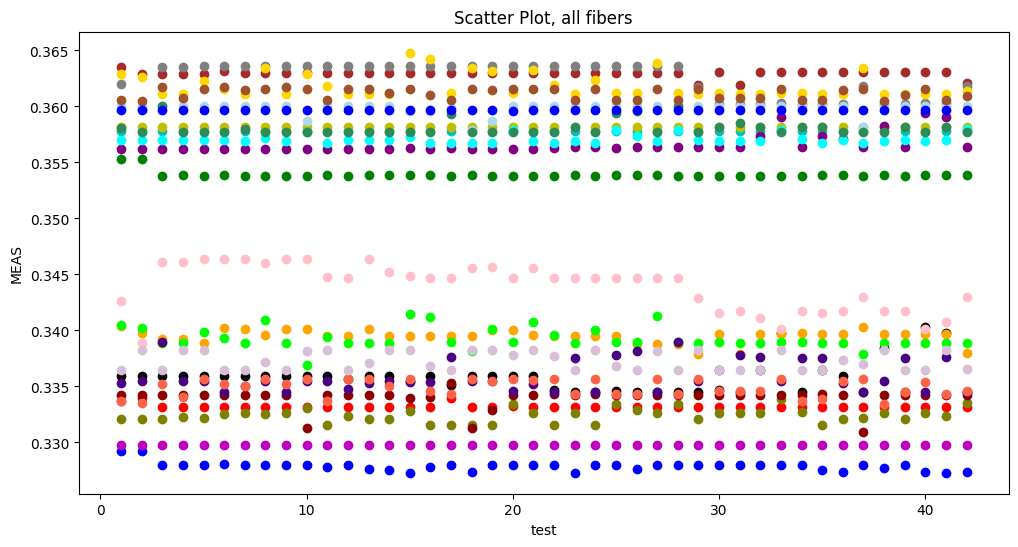

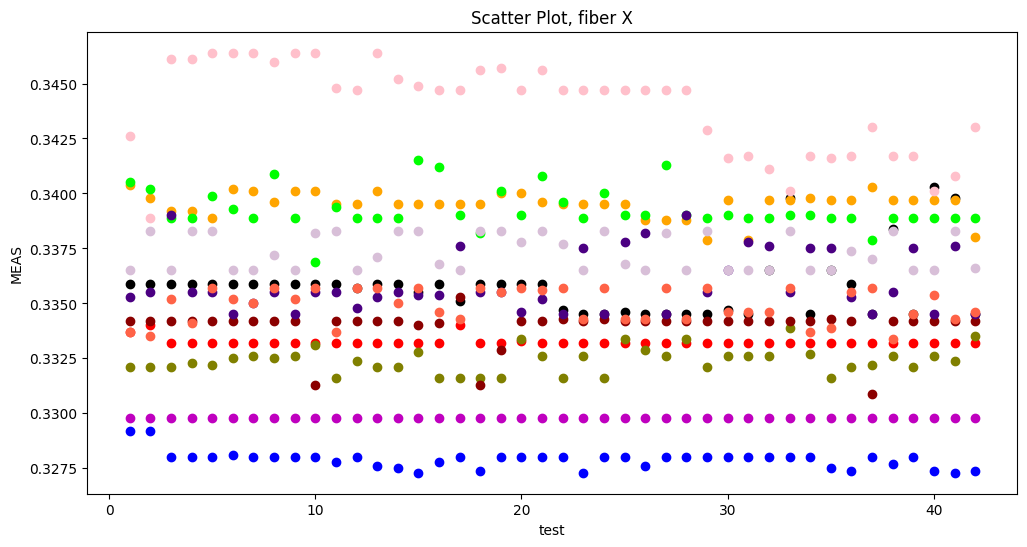

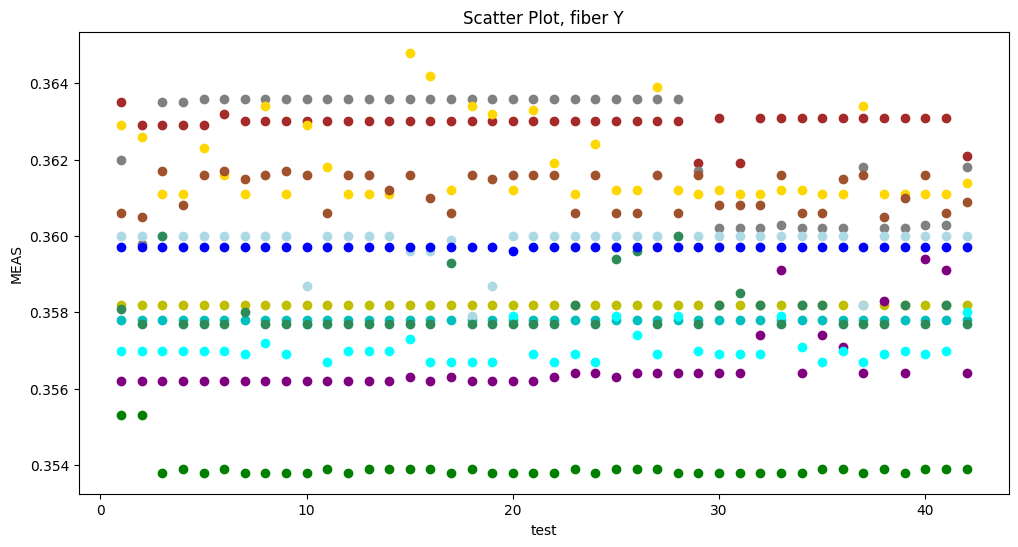

In [13]:
##Visualizations
fig = plot_scatter(MEAS, title='Scatter Plot, all fibers', xlabel='test', ylabel='MEAS') #Plot all guides
fig = plot_scatter(MEAS, title='Scatter Plot, fiber X', xlabel='test', ylabel='MEAS', filter='x') #Plot x axis values
fig = plot_scatter(MEAS, title='Scatter Plot, fiber Y', xlabel='test', ylabel='MEAS', filter='y') #Plot y axis values

In [14]:
##Descriptive statistics
RESUME = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns.
RESUME_format = rename_index(RESUME)
display(RESUME_format)

,count,mean,std,min,25%,50%,75%,max
Guia_Luz_Blanco_FB1_X,42.0,0.327893,3.922374e-04,0.3273,0.327625,0.32800,0.328000,0.3292
Guia_Luz_Blanco_FB1_Y,42.0,0.353914,3.174375e-04,0.3538,0.353800,0.35380,0.353900,0.3553
Guia_Luz_Blanco_FB2_X,42.0,0.333252,1.864143e-04,0.3332,0.333200,0.33320,0.333200,0.3340
Guia_Luz_Blanco_FB2_Y,42.0,0.357800,0.000000e+00,0.3578,0.357800,0.35780,0.357800,0.3578
Guia_Luz_Blanco_FB3_X,42.0,0.329800,5.618404e-17,0.3298,0.329800,0.32980,0.329800,0.3298
Guia_Luz_Blanco_FB3_Y,42.0,0.358200,0.000000e+00,0.3582,0.358200,0.35820,0.358200,0.3582
Guia_Luz_Blanco_FB4_X,42.0,0.335790,1.424662e-03,0.3345,0.334525,0.33590,0.335900,0.3403
Guia_Luz_Blanco_FB4_Y,42.0,0.356610,8.357294e-04,0.3562,0.356200,0.35630,0.356400,0.3594
Guia_Luz_Blanco_FB5_X,42.0,0.339510,5.805000e-04,0.3379,0.339500,0.33960,0.339775,0.3404
Guia_Luz_Blanco_FB5_Y,42.0,0.362960,2.963679e-04,0.3619,0.363000,0.36300,0.363100,0.3635


Analysis of faulty fibers

In [15]:
##Analysis of faulty fibers
std = pd.DataFrame(RESUME_format['std'])  #Get the std values
fiber_number = rename_index(pd.DataFrame(range(1, std.shape[0]+1))).rename(columns={0: 'Fiber number'}) #Adds an absolute fiber number for quick identification
LARGEST = pd.concat([std, fiber_number], axis = 1).sort_values(by="std", ascending=False)[:5]  #Filters the 5 largest values
display(LARGEST)

,std,Fiber number
Guia_Luz_Blanco_FB6_X,0.002104,11
Guia_Luz_Blanco_FB6_Y,0.001538,12
Guia_Luz_Blanco_FB4_X,0.001425,7
Guia_Luz_Blanco_FB10_X,0.001346,19
Guia_Luz_Blanco_FB9_Y,0.001060,18


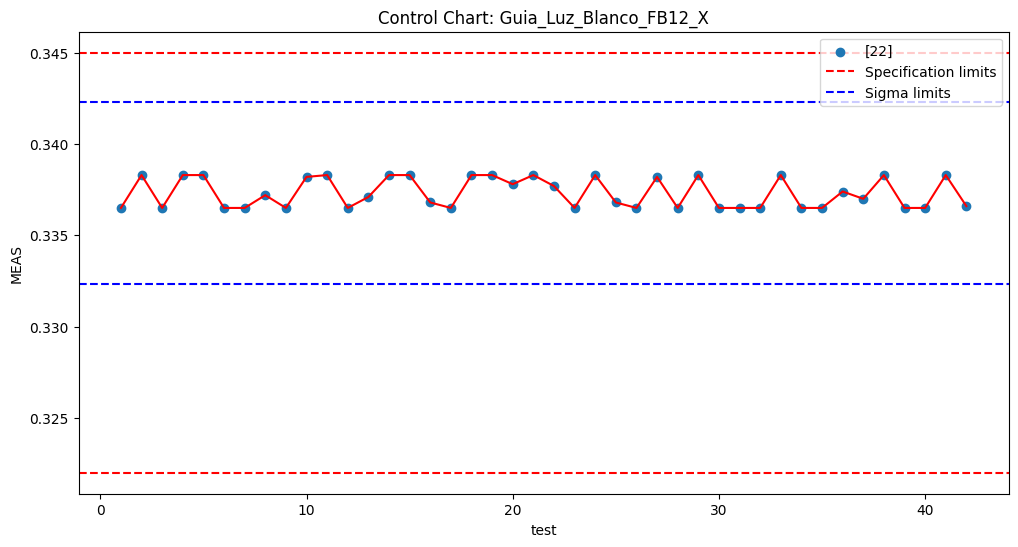

In [24]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
plot_control_chart(MEAS_format, title=f'Control Chart: {fiber_selection.value}', xlabel='test', ylabel='MEAS', LIMITS=LIMITS, fiber=fiber_selection.value, yrange=yrange)

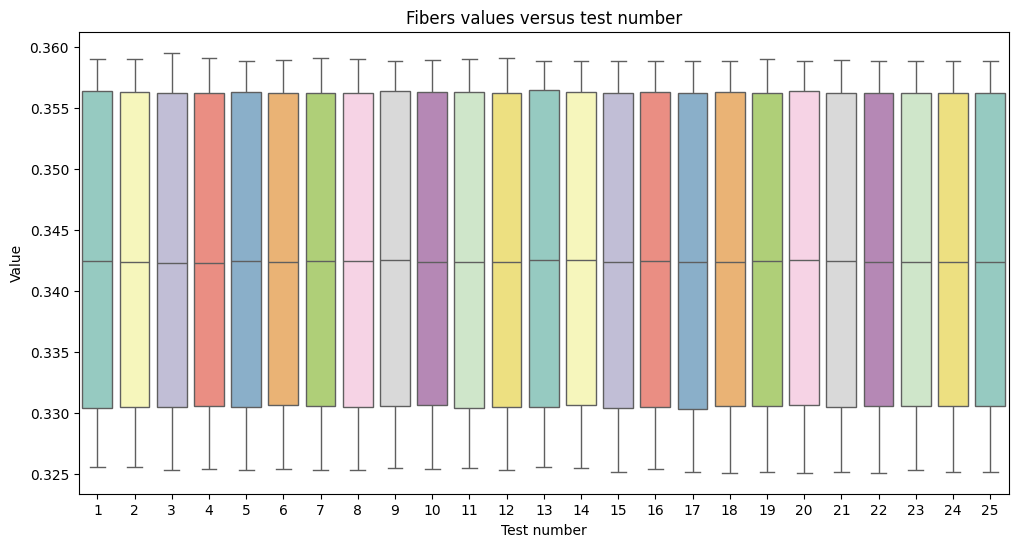

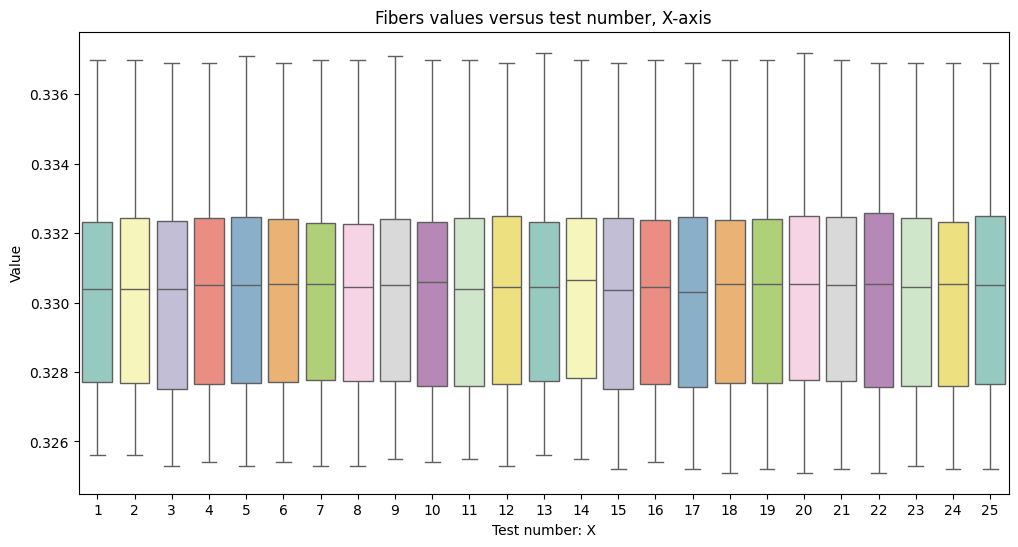

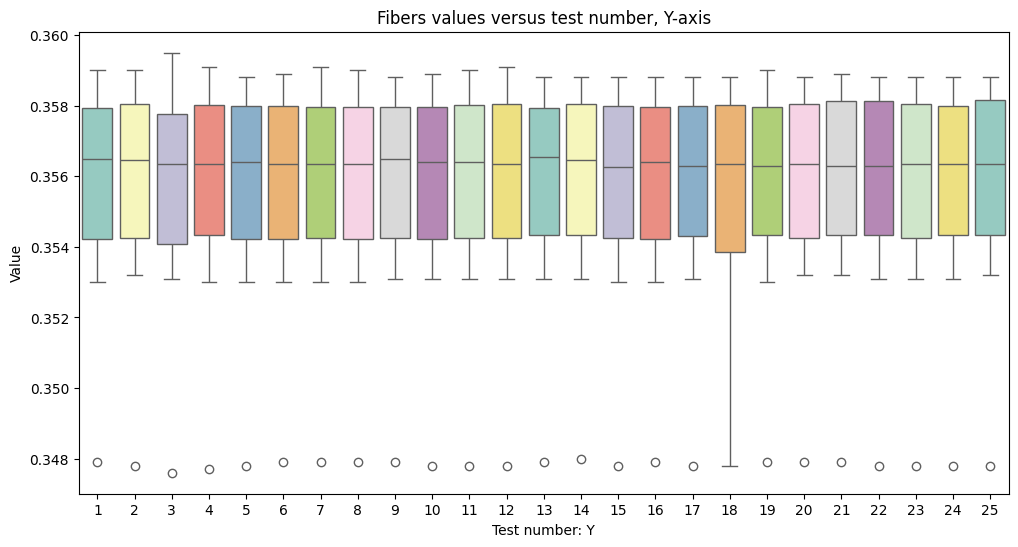

In [12]:
##Boxplot visualization
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number", xlabel="Test number", ylabel="Value", filter=None)
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number, X-axis", xlabel="Test number: ", ylabel="Value", filter="X")
fig = plot_boxplot(MEAS_format, title="Fibers values versus test number, Y-axis", xlabel="Test number: ", ylabel="Value", filter="Y")
#fig = plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="X", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))

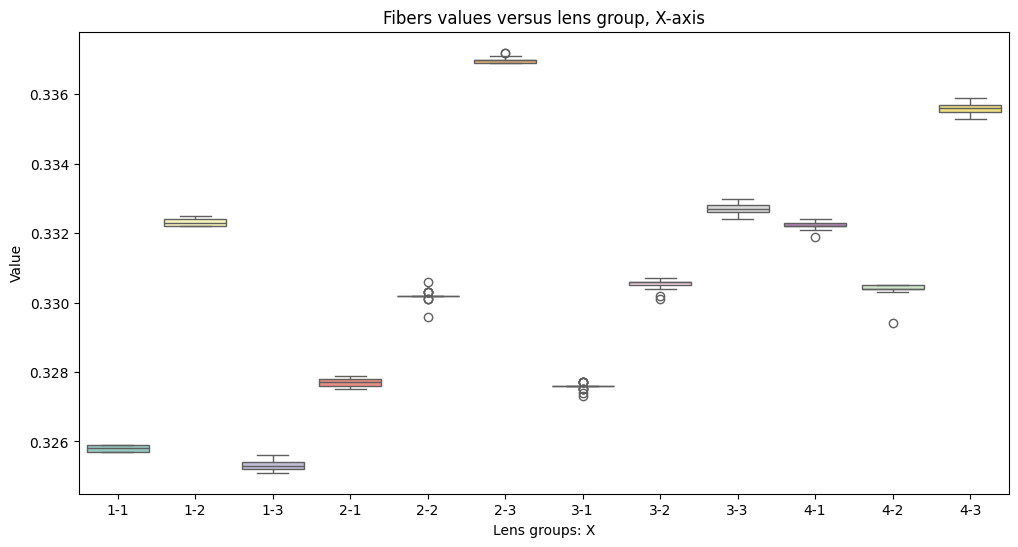

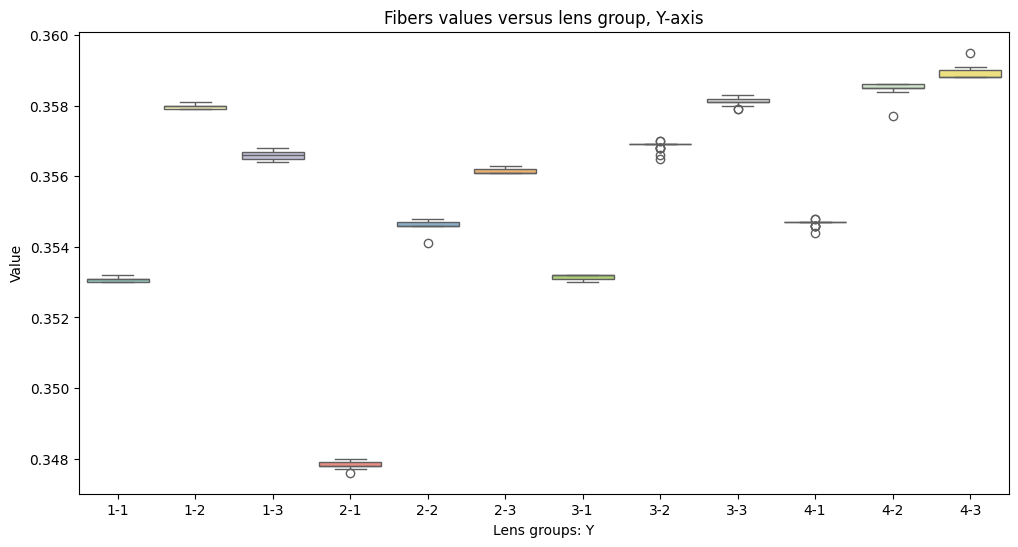

In [13]:
fig = plot_boxplot(MEAS_format.transpose(), title="Fibers values versus lens group, X-axis", xlabel="Lens groups: ", ylabel="Value", filter="X", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))
fig = plot_boxplot(MEAS_format.transpose(), title="Fibers values versus lens group, Y-axis", xlabel="Lens groups: ", ylabel="Value", filter="Y", lenses_per_nest=int(FIXTURE_DATA.loc["Lenses per nest", "Tooling data"]))

In [15]:
######Terminar
##Data export
date = get_date()
name_xlsx = glob.tooling + "_EDA_" + get_date() + ".xlsx"
name_scatter = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_scatter_" + date + ".pdf"
name_bloxplot = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_boxplot_" + date + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.abspath("../a2_output/reports")
    DATA = pd.concat([MEAS_format, LIMITS_format], axis=1)
    plot_to_pdf(MEAS, name=name_scatter, plot="SCATTER")
    plot_to_pdf([MEAS_format, FIXTURE_DATA], name=name_bloxplot, plot="BOXPLOT")
    output_html([FIXTURE_DATA, MEAS_format, LIMITS_format, RESUME_format, LARGEST], "EDA.html")
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Analysis data and visualizations exported inside:
c:\Users\User\Desktop\Luciano\Python_Eiit_RyR\a2_Analyser\a2_output
